# End-to-end ML project for Pnemunia diagnosis

## Data download

In [1]:
from tools.data_downloader import download_from_kaggle
from tools.data_analysis import *

/home/sagemaker-user/X_ray_project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
download_from_kaggle()

100%|██████████| 2.29G/2.29G [00:24<00:00, 99.9MB/s]

Extracting files...


Data downloaded into the cache path:/home/sagemaker-user/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2 
 Copying dataset to: /home/sagemaker-user/X_ray_project/dataset
 Clearing Kagglehub cache: /home/sagemaker-user/.cache/kagglehub
done!


PosixPath('/home/sagemaker-user/X_ray_project/dataset')

## Data exploration

In [3]:
data_path="dataset/chest_xray/train"
class_balance(data_path)

Train data class balance:
----------------------------------------
NORMAL    :  1341 ( 25.7%)
PNEUMONIA :  3875 ( 74.3%)
----------------------------------------
Total images: 5216
CI score: 2.89
Prone to bias in the final model!


{'NORMAL': 1341, 'PNEUMONIA': 3875}

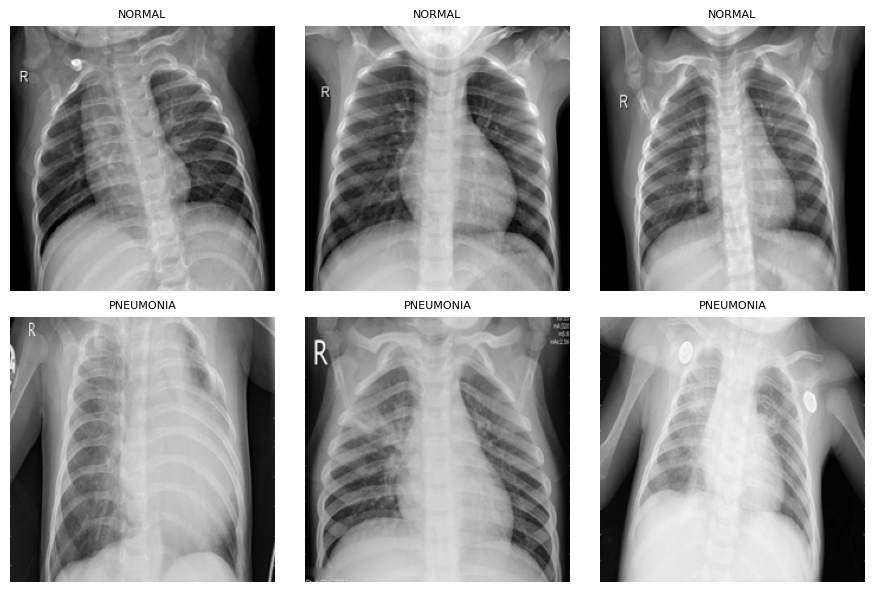

Image format: JPEG
Image size: (1040, 640)
Image_mode : L


In [4]:
show_random_images(data_path)

## Data preparation for training

In [5]:
from tools.data_preparation import create_lst_files, train_test_split,image_resizer
import os
# first split the dataset
root_dir = "dataset/chest_xray"
train_dir=os.path.join(root_dir,"train")
val_dir=os.path.join(root_dir,"val")
train_test_split(train_dir,val_dir)

Class 'NORMAL': total=1341, moved to val=67, remaining in train=1274
Class 'PNEUMONIA': total=3875, moved to val=193, remaining in train=3682


In [1]:
# We should create lst files for sagemaker training
from tools.data_preparation import create_lst_files
root_dir = "dataset/chest_xray"

for split in ["train", "val","test"]:
    try:
         image_resizer(root_dir,split)
        create_lst_files(root_dir, split)
    except Exception as e:
        print(f"[ERROR] Failed to create .lst for split '{split}': {e}")
        


[train] class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
train data wrote 4956 entries to dataset/chest_xray/train.lst
[val] class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
val data wrote 276 entries to dataset/chest_xray/val.lst
[test] class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
test data wrote 624 entries to dataset/chest_xray/test.lst


In [2]:
from tools.file_shuffler import shuffle_lst
import os
# shuffling the .lst file in the end
shuffle_lst(os.path.join(root_dir,"train.lst"))
shuffle_lst(os.path.join(root_dir,"val.lst"))

## Creating S3 bucket and data transfer

In [3]:
from tools.data_uploader import upload_dataset, cleanup_dataset
import sagemaker
sess=sagemaker.Session()
bucket=sess.default_bucket()
print(f"Sage maker bucket {bucket} created")
root_dir = "dataset/chest_xray"
base_prefix="chest-xray"
upload_dataset(root_dir,bucket,base_prefix)
cleanup_dataset(root_dir)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Sage maker bucket sagemaker-us-east-1-155576114785 created
All files uploaded successfully from dataset/chest_xray/train
All files uploaded successfully from dataset/chest_xray/val
All chest X-ray data and .lst files uploaded.

Starting cleanup...
Deleted folder: dataset/chest_xray/train
Deleted folder: dataset/chest_xray/val
Deleted file: dataset/chest_xray/train.lst
Deleted file: dataset/chest_xray/val.lst
Cleanup completed.



## Training preparations

### Step 1: Imports

In [4]:
import sagemaker
from sagemaker import image_uris
from sagemaker.session import Session
from sagemaker import get_execution_role
import boto3

sess=Session()
role=get_execution_role()
prefix="chest-xray"
train_images_s3 = f"s3://{bucket}/{prefix}/train"
val_images_s3   = f"s3://{bucket}/{prefix}/validation"
train_lst_s3    = f"s3://{bucket}/{prefix}/train_lst"
val_lst_s3      = f"s3://{bucket}/{prefix}/validation_lst"
print(role)

arn:aws:iam::155576114785:role/service-role/AmazonSageMaker-ExecutionRole-20251107T114371


### Step 2: Built-in model retrieve

In [5]:
algorithm_img = image_uris.retrieve(
    region=sess.boto_region_name,
    framework="image-classification"
)
print("Algorithm image URI:", algorithm_img)


Algorithm image URI: 811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1


### Step3: Creating training channels

In [8]:
from sagemaker.inputs import TrainingInput

# assume you already have:
# bucket = "your-bucket-name"

data_channels = {
    "train": TrainingInput(
        s3_data=train_images_s3 ,
        content_type="application/x-image",
        s3_data_type="S3Prefix",
    ),
    "validation": TrainingInput(
        s3_data=val_images_s3,
        content_type="application/x-image",
        s3_data_type="S3Prefix",
    ),
    "train_lst": TrainingInput(
        s3_data=train_lst_s3,
        content_type="text/plain",
        s3_data_type="S3Prefix",
    ),
    "validation_lst": TrainingInput(
        s3_data=val_lst_s3,
        content_type="text/plain",
        s3_data_type="S3Prefix",
    )
}


### Step 4: Creating the estimator

In [9]:
from sagemaker.estimator import Estimator
output_path=f"s3://{bucket}/{prefix}/output"
print(f" output path: {output_path}")

img_classifier = Estimator(
    image_uri=algorithm_img,
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.4xlarge",
    volume_size=50,
    max_run=36000,
    input_mode="File",
    output_path=output_path,
    sagemaker_session=sess
)
print(img_classifier)


 output path: s3://sagemaker-us-east-1-155576114785/chest-xray/output


### Step 5: Setting the hyperparmeters

In [10]:
img_classifier.set_hyperparameters(
    use_pretrained_model=1,
    image_shape='3,224,224',
    num_layers=101,
    num_classes=2,
    learning_rate=0.1,
    num_training_samples= 4956,
    epochs=30,
    early_stopping=True,
    early_stopping_min_epochs=8,
    early_stopping_patience=5,
    lr_scheduler_step = "10,20",
    lr_scheduler_factor=0.1,
    augmentation_type="crop_color_transform", 
)

In [11]:
print(img_classifier)

### (Optional) Step 6: Defining a tunning job for better generalization

In [12]:
# from sagemaker.tuner import HyperparameterTuner,CategoricalParameter,ContinuousParameter
# hyper_parameter_range={
#     "learning_rate":ContinuousParameter(0.001,0.1),
#     "mini_batch_size":CategoricalParameter([8,16,32]),
# }
# # tuning job definition
# objective_metric_name="validation:accuracy"
# objective_type="Maximize"
# max_jobs=5
# max_parallel_jobs=2
# model_tuner = HyperparameterTuner(estimator=img_classifier,
#                                 objective_metric_name=objective_metric_name,
#                                 objective_type=objective_type,
#                                 hyperparameter_ranges=hyper_parameter_range,
#                                 max_jobs=max_jobs,
#                                 max_parallel_jobs=max_parallel_jobs

# )
# import time
# prefix = "X-ray-classifier"
# time_stamp=time.strftime("-%H-%M-%S",time.localtime())
# job_name = prefix + time_stamp
# model_tuner.fit(inputs=data_channels,
# job_name=job_name,
# logs=True)

### Step 7: Training

In [13]:
import time
prefix = "X-ray-classifier"
time_stamp=time.strftime("%d-%H-%M-%S",time.localtime())
job_name = prefix + time_stamp
img_classifier.fit(inputs=data_channels,
job_name=job_name,
logs=True)

INFO:sagemaker:Creating training-job with name: X-ray-classifier13-20-22-54


2025-12-13 20:22:54 Starting - Starting the training job
2025-12-13 20:22:54 Pending - Training job waiting for capacity......
2025-12-13 20:23:35 Pending - Preparing the instances for training...
2025-12-13 20:24:25 Downloading - Downloading the training image............
2025-12-13 20:26:16 Training - Training image download completed. Training in progress.....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sat Dec 13 20:26:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.195.03             Driver Version: 570.195.03     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |    

### Step 8: Evaluation

In [1]:
bucket = "sagemaker-us-east-1-155576114785"

In [ ]:
# Upload test data into S3, exclude the .lst file it shall be used for ground truth extraction only 
import os
import sagemaker
sess = sagemaker.Session()
prefix = "chest-xray"
local_path = "dataset/chest_xray"
sess.upload_data(
    path=os.path.join(local_path,"test"),
    bucket=bucket,
    key_prefix = f"{prefix}/test"
)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
import sagemaker
from sagemaker.model import Model
role=sagemaker.get_execution_role()
model_data = "s3://sagemaker-us-east-1-155576114785/chest-xray/output/X-ray-classifier13-20-22-54/output/model.tar.gz"
image_uri = sagemaker.image_uris.retrieve(
    framework="image-classification",
    region=sess.boto_region_name,
    version="1"
)
trained_model=Model(
    image_uri=image_uri,
    model_data=model_data,
    role=role,
    sagemaker_session=sess,
     env={"NUM_CLASSES": "2"}
)
 

In [4]:
transformer = trained_model.transformer(
    instance_count=1,
    instance_type="ml.m4.2xlarge",
    strategy="SingleRecord",
    assemble_with="Line",
    output_path=f"s3://{bucket}/chest-xray/inference",
    accept="application/json"
)
transformer.transform(
    data =f"s3://{bucket}/chest-xray/test",
    content_type="application/x-image"
)

INFO:sagemaker:Creating transform job with name: image-classification-2025-12-22-00-14-54-402


...................................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[12/22/2025 00:23:27 INFO 140384970901312] loaded entry point class algorithm.serve.server_config:config_api
[12/22/2025 00:23:27 INFO 140384970901312] loading entry points
[12/22/2025 00:23:27 INFO 140384970901312] loaded request iterator application/x-image
[12/22/2025 00:23:27 INFO 140384970901312] loaded request iterator image/jpeg
[12/22/2025 00:23:27 INFO 140384970901312] loaded request iterator image/png
[12/22/2025 00:23:27 INFO 140384970901312] loaded response encoder application/json
[12/22/2025 00:23:27 INFO 140384970901312] loaded response encoder application/jsonlines
[12/22/2025 00:23:27 INFO 140384970901312] loaded entry point class algorithm:model
[12/22/2025 00:23

In [3]:
# Download inferences to local path
!mkdir -p inferences
!aws s3 cp s3://sagemaker-us-east-1-155576114785/chest-xray/inference/ inferences/ --recursive

download: s3://sagemaker-us-east-1-155576114785/chest-xray/inference/NORMAL/IM-0001-0001.jpeg.out to inferences/NORMAL/IM-0001-0001.jpeg.out
download: s3://sagemaker-us-east-1-155576114785/chest-xray/inference/NORMAL/IM-0009-0001.jpeg.out to inferences/NORMAL/IM-0009-0001.jpeg.out
download: s3://sagemaker-us-east-1-155576114785/chest-xray/inference/NORMAL/IM-0003-0001.jpeg.out to inferences/NORMAL/IM-0003-0001.jpeg.out
download: s3://sagemaker-us-east-1-155576114785/chest-xray/inference/NORMAL/IM-0005-0001.jpeg.out to inferences/NORMAL/IM-0005-0001.jpeg.out
download: s3://sagemaker-us-east-1-155576114785/chest-xray/inference/NORMAL/IM-0006-0001.jpeg.out to inferences/NORMAL/IM-0006-0001.jpeg.out
download: s3://sagemaker-us-east-1-155576114785/chest-xray/inference/NORMAL/IM-0007-0001.jpeg.out to inferences/NORMAL/IM-0007-0001.jpeg.out
download: s3://sagemaker-us-east-1-155576114785/chest-xray/inference/NORMAL/IM-0011-0001-0001.jpeg.out to inferences/NORMAL/IM-0011-0001-0001.jpeg.out
dow

### Step 9:Evaluation report

In [1]:
from tools.model_evaluation import batch_evaluation
lst_path="dataset/chest_xray/test.lst"
inference_path="inferences"
report=batch_evaluation(lst_path,inference_path)
print(report)

Total lst entries: 624
Predictions found: 624
              precision    recall  f1-score   support

      NORMAL      0.961     0.423     0.588       234
   PNEUMONIA      0.741     0.990     0.847       390

    accuracy                          0.777       624
   macro avg      0.851     0.706     0.717       624
weighted avg      0.823     0.777     0.750       624



### Step 10: Deployment

In [5]:
# 10.1: 
# Endpoint definition
endpoint_name = "Demo-image-classifier"
deployment_point = trained_model.deploy(
    initial_instance_count=1,
    instance_type = "ml.m4.2xlarge",
    endpoint_name=endpoint_name
)

------------!